# GPPVAE demo

This notebook demonstrates the use of my GPPVAE implementation in with a basic configuration. The aim is to implement a mixed Gaussian prior VAE using a GPPVAE approach. This serves as a proof-of-concept for further development.

In [1]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
#sys.path.append("/home/santeri/repos/HIT_VAE")
sys.path.append("/u/14/mentus1/unix/repos/HIT_VAE")

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting
from hit_vae.basic_kernels.constant_kernel import ConstantKernel
from hit_vae.basic_kernels.categorical_kernel import CategoricalKernel
from hit_vae.basic_kernels.input_warping_kernel import InputWarpKernel

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


## Loading the data

The beginning is the same as in the VAE demo

In [5]:
data_base_path = '../../data/mnist_gen'
# csv which contains the IDs and labels for the training data
label_path = os.path.join(data_base_path, 'labels.csv')
label_df = pd.read_csv(label_path, index_col=0)
labels = torch.Tensor(label_df.values)
#labels = label_df.to_dict(orient='index')
# we also store all the labels in a separate list
#list_IDs = list(labels.keys())
list_IDs = range(len(labels))

In [6]:
# for expariments use 30% of the samples for testing and validation and 70% for training
test_ratio = 0.3

# transformations applied to samples
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# we use the Dataset class defined in utils to store the data
training_set = data_loading.TensorLabelDataset(data_base_path, list_IDs, labels, transform=transform)

n_train = len(training_set)
#indices = list(labels.keys())
indices = np.arange(len(training_set))
np.random.shuffle(indices) # we randomize the order of the samples

test_split = int(np.floor(test_ratio * n_train))
test_IDs, training_IDs = indices[:test_split], indices[test_split:]
#print(labels[training_IDs])

We define a custom sampler for loading the data in the same order each epoch

In [7]:
from torch.utils.data import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements sequentially, always in the same order.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [8]:
# change the number of workers based on your CPU
loader_params = {'batch_size': 32, 'num_workers': 4}

#training_sampler = data.SubsetRandomSampler(training_IDs)
#test_sampler = data.SubsetRandomSampler(test_IDs)

training_sampler = SubsetSampler(training_IDs)
test_sampler = SubsetSampler(test_IDs)

# torch data loaders with parallelization for efficiency
training_loader = data.DataLoader(training_set, **loader_params, sampler=training_sampler)
test_loader = data.DataLoader(training_set, **loader_params, sampler=test_sampler)

In [9]:
# sanity check for the training data
image_sample, label_sample = iter(training_loader).next()
print(label_sample[0:10].view(-1))

tensor([1., 1., 8., 7., 5., 6., 9., 6., 2., 3.])


## Neural network

For this demo I use the same simple convolutional network model as in the VAE demo. The latent space is two dimensional for better interpretability of the results.

In [10]:
# initialize the model defined in the models module
ldim = 2
vae_model = mnist_conv_vae.DigitVae(ldim=ldim)
vae_model.to(device)

DigitVae(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=2, bias=True)
  (fc22): Linear(in_features=32, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (deconv1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

The model is pretrained using a normal VAE prior, as was done by Casale et al. in their paper.

In [11]:
ckpt_name = 'basic_conv_vae_noise_MNIST.pt'
load_path = '../../trained_models'
vae_model.load_state_dict(torch.load(os.path.join(load_path, ckpt_name)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
vae_model.eval()

recon_images, Z, logvar = vae_model(image_sample.to(device))
print(Z)

tensor([[-2.3126,  0.2491],
        [-1.8424,  2.4277],
        [ 0.0450,  0.3196],
        [-0.3684, -1.8128],
        [-0.7766,  0.0579],
        [-0.1233,  1.5548],
        [ 1.0539, -0.8898],
        [ 0.3711,  2.6585],
        [ 0.3677,  1.1195],
        [-0.0274, -1.1952],
        [-0.7053, -0.2340],
        [ 0.1536, -0.6339],
        [ 0.7221,  0.1809],
        [-1.5440, -2.2160],
        [ 1.0500,  1.2525],
        [ 1.1839, -0.0552],
        [ 2.6591,  0.3098],
        [-0.1465, -1.6391],
        [-0.5658, -1.9926],
        [-0.4772,  1.5202],
        [-0.6106,  1.5354],
        [ 1.0634, -1.0201],
        [-0.0556,  0.3623],
        [-1.1990, -0.0974],
        [ 2.5583,  0.0340],
        [ 1.5573,  0.7699],
        [ 0.5992,  0.0600],
        [-0.4147, -2.1854],
        [ 0.1288, -2.0028],
        [ 1.6206,  0.1421],
        [-0.6355, -0.2102],
        [ 0.5083,  0.3779]], device='cuda:0', grad_fn=<AddmmBackward>)


## GP prior

In order to set a GP prior on the latent space, we use two identical gaussian process models, which are trained simultaneously with the neural network.

In [13]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [14]:
#covar_module = ScaleKernel(ConstantKernel(active_dims=0)) * CategoricalKernel(active_dims=0)
#covar_module = ScaleKernel(CategoricalKernel(active_dims=0))
covar_module = ScaleKernel(RBFKernel(active_dims=0))

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

In [16]:
training_labels = labels[training_IDs].to(device)
placeholder_targets = torch.zeros(len(training_labels)).view(-1)

print(training_labels.shape)
print(placeholder_targets.shape)

# initialize the GP models using sample data
gp_x = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)
gp_y = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)

torch.Size([630, 1])
torch.Size([630])


In [17]:
gp_x

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

## Training the model

In [18]:
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.0001)
gp_x_optimizer = optim.Adam([ {'params': gp_x.parameters()},], lr=0.01)
gp_y_optimizer = optim.Adam([ {'params': gp_y.parameters()},], lr=0.01)

training_labels = labels[training_IDs].to(device)

In [19]:
mll_x = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_x)
mll_y = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_y)

In [20]:
def train(epoch):
    
    gp_weight = 1
    
    data = torch.tensor([]).to(device)
    raw = torch.tensor([]).to(device)
    Z = torch.tensor([]).to(device)
    logvars = torch.tensor([]).to(device)
    recon_data = torch.tensor([]).to(device)
    #labels_during_training = torch.tensor([]).to(device)
    
    # 1. encode, sample, reconstruct
    
    for batch_idx, (data_batch, labels) in enumerate(training_loader):
        
        data_batch = data_batch.to(device)
        recon_batch, mu, logvar = vae_model(data_batch)
        #print('this is mu: {}'.format(mu))
        
        Z_samples = vae_model.sample_latent(mu, logvar)
        
        raw = torch.cat((raw, mu), dim=0)
        Z = torch.cat((Z, Z_samples), dim=0)
        logvars = torch.cat((logvars, logvar), dim=0)
        data = torch.cat((data, data_batch), dim=0)
        recon_data = torch.cat((recon_data, recon_batch), dim=0)
        #labels_during_training = torch.cat((labels_during_training, labels.to(device)), dim=0)
    
    #print(labels_during_training)
    #print(training_labels)
    
    # 2. calculate loss on the encodings
    
    training_Z = Z
    training_x = training_Z[:,0].view(-1)
    training_y = training_Z[:,1].view(-1)
    
    gp_x.set_train_data(training_labels, training_x)
    gp_y.set_train_data(training_labels, training_y)
    
    output_x, output_y = gp_x(training_labels), gp_y(training_labels)
    
    #print(output)
    
    recon_loss = losses.recon_loss(recon_data, data) / len(test_loader.dataset)
    gp_x_loss = -mll_x(output_x, training_x) * gp_weight
    gp_y_loss = -mll_y(output_y, training_y) * gp_weight
    
    #print(output_x)
    #print(training_x.shape)
    
    #print(output_x)
    #print(training_labels.shape)
    #print(gp_x_loss)
    
    pen_term = -0.5 * logvars.sum() / len(test_loader.dataset)
    
    #print(recon_loss)
    #print(gp_x_loss)
    #print(gp_y_loss)
    #print(pen_term)
    
    loss = (recon_loss + gp_x_loss + gp_y_loss + pen_term)
    
    #for param_name, param in gp_x.named_parameters():
    #    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
    # 3. backwards operations
    
    loss.backward()
    
    vae_optimizer.step()
    gp_x_optimizer.step()
    gp_y_optimizer.step()
    
    
    # 4. visualize
    if epoch % 20 == 0:
        plotting.visualize_latent_2D(raw.detach().cpu().numpy(), training_labels.view(-1).cpu().numpy(), colormap='Set1',
                                    savepath='../../results/GPPVAE/epoch{:04d}'.format(epoch))
        #_ = model_demo(training_loader, 'timestamp', 'viridis')
    
    return gp_x_loss.detach().cpu().numpy() + gp_y_loss.detach().cpu().numpy(), recon_loss.detach().cpu().numpy(), pen_term.detach().cpu().numpy()

In [21]:
epochs = 4000

gp_losses = []
vae_losses = []
penalty_terms = []

vae_model.train()
gp_x.train()
gp_y.train()

for epoch in range(epochs):
    gp_loss, vae_loss, pen = train(epoch)
    
    gp_losses.append(gp_loss)
    vae_losses.append(vae_loss)
    penalty_terms.append(pen)
  

/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.21201753616333 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 5.17155122756958 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterati

/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.5267493724823 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 2789.899169921875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterati

RuntimeError: NaNs encounterd when trying to perform matrix-vector multiplication

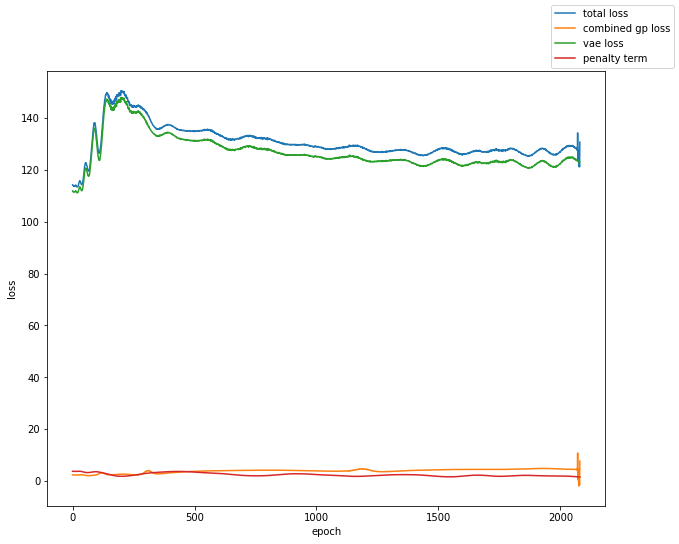

In [22]:
total_losses = [vae_losses[i] + gp_losses[i] for i in range(len(gp_losses))]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(total_losses, label='total loss')
ax.plot(gp_losses, label='combined gp loss')
ax.plot(vae_losses, label='vae loss')
ax.plot(penalty_terms, label='penalty term')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.legend()
plt.savefig('../../results/GPVAE_loss.png')

plt.show()

Make a little gif of the evolution of the latent representation

## Evaluating the model

Make a little gif of the evolution of the latent representation

In [23]:
import imageio

files = os.listdir('../../results/GPPVAE')
files = np.sort(files)
#print(files)
filenames = [f'../../results/GPPVAE/{file}' for file in files]

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('../../results/GPPVAE_anim.gif', images, duration=0.2)

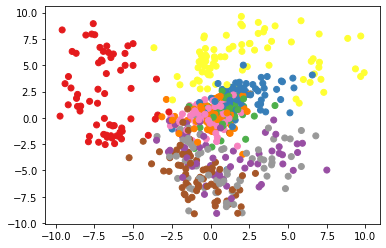

In [24]:
x = gp_x.train_targets.detach().cpu().numpy()
y = gp_y.train_targets.detach().cpu().numpy()
l = gp_x.train_inputs[0].view(-1).detach().cpu().numpy()

plt.scatter(x, y, c=l, cmap='Set1')

In [25]:
#hypers = {
#    'likelihood.noise_covar.raw_noise': torch.tensor(-0.19).to(device),
#   'covar_module.outputscale': torch.tensor(0.16).to(device),
#}

#gp_x.initialize(**hypers)

#gp_x.likelihood.noise_covar.noise = -0.19
gp_x.covar_module.outputscale = .8

for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
#print(gp_x.train_inputs)

Parameter name: likelihood.noise_covar.raw_noise           value = 7.392612934112549
Parameter name: mean_module.constant                       value = -2.443570852279663
Parameter name: covar_module.raw_outputscale               value = 0.20338228344917297
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -42.1799430847168


In [26]:
gp_x.eval()
gp_y.eval()

test_ids = np.repeat(np.arange(1, 10), np.repeat(3, 9), axis=0)
#print(test_ids)
test_labels = torch.tensor(test_ids, dtype=torch.float).to(device)

pred_x = likelihood(gp_x(test_labels))
pred_y = likelihood(gp_y(test_labels))

/u/14/mentus1/unix/.conda/envs/gppvae/lib/python3.6/site-packages/gpytorch/lazy/added_diag_lazy_tensor.py:62: UserWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  "NaNs encountered in preconditioner computation. Attempting to continue without preconditioning."


RuntimeError: NaNs encounterd when trying to perform matrix-vector multiplication

In [ ]:
plt.scatter(pred_x.mean.detach().cpu().numpy(), pred_y.mean.detach().cpu().numpy(), 
            c=test_labels.view(-1).cpu().numpy(), cmap='Set1')
plt.show()

In [ ]:
#print(training_labels)